In [36]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopandas
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

import html5lib
!pip install lxml

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
# The code was removed by Watson Studio for sharing.

# Toronto

In [ ]:
#Toronto data
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dflist = pd.read_html(wiki_url)[0]
#Pre-processing
#drop rows with Borough='Not assigned'
df=dflist.drop(dflist.index[dflist.Borough=='Not assigned'])
df.sort_values(by=['Postal Code'], inplace=True)
df.reset_index(drop=True, inplace=True)
!wget -q -O 'toronto_data.csv' http://cocl.us/Geospatial_data
geodf=pd.read_csv('toronto_data.csv')
df.set_index('Postal Code', inplace=True)
geodf.set_index('Postal Code',  inplace=True)
toronto_df=df.merge(geodf, left_index=True, right_index=True)
toronto_df.reset_index(inplace=True)

torontocity_data = toronto_df[toronto_df['Borough'].str.contains('Toronto')].reset_index(drop=True)
df_toronto1 = torontocity_data.drop(['Postal Code'], axis=1)
print(df_toronto1.shape)
df_toronto1.head()

In [ ]:
df_toronto=df_toronto1.set_index(['Borough','Latitude','Longitude']).stack().str.split(',', expand=True).stack()
df_toronto=df_toronto.unstack(-2).reset_index(-1,drop=True).reset_index()
df_toronto = df_toronto.reindex(columns=['Borough','Neighborhood','Latitude', 'Longitude'])
print(df_toronto.shape)
df_toronto.head(78)

In [ ]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [ ]:
#Function to have all the venue from the different neighborhoods
LIMIT=500
radius=500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

In [ ]:
print(toronto_venues.shape)
toronto_venues.head()

# New York

In [ ]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

with open('newyork_data.json') as json_data:
        newyork_data = json.load(json_data)

In [ ]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


df_ny=neighborhoods
print(df_ny.shape)
df_ny.head()


In [ ]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_ny['Latitude'], df_ny['Longitude'], df_ny['Borough'], df_ny['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [ ]:
ny_venues = getNearbyVenues(names=df_ny['Neighborhood'],
                                   latitudes=df_ny['Latitude'],
                                   longitudes=df_ny['Longitude']
                                  )

In [ ]:
print(ny_venues.shape)
ny_venues.head()

# Zurich

In [50]:
wiki_z='https://en.wikipedia.org/wiki/Subdivisions_of_Z%C3%BCrich'
df = pd.read_html(wiki_z)[1]
df=pd.DataFrame(df)
df= df[df.District.str.get(0).isin(['D'])]
df.drop(['Location', 'Coat of Arms', 'BFS-Code', 'Incorporation', 'Areain km²','Population2005','Non-Swiss Citizens'],axis=1,inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(20)

,District,Neighborhood
0,District 1Altstadt,Rathaus Hochschulen Lindenhof City
1,District 2,Wollishofen Leimbach Enge
2,District 3Wiedikon,Alt-Wiedikon Friesenberg Sihlfeld
3,District 4Aussersihl,Werd Langstrasse Hard
4,District 5Industriequartier,Gewerbeschule Escher Wyss
5,District 6,Unterstrass Oberstrass
6,District 7,Fluntern Hottingen Hirslanden Witikon
7,District 8Riesbach,Seefeld Mühlebach Weinegg
8,District 9,Albisrieden Altstetten
9,District 10,Höngg Wipkingen


In [51]:
#rename District name
town=['Zurich','Zurich','Zurich','Zurich','Zurich','Zurich','Zurich','Zurich','Zurich','Zurich','Zurich','Zurich']
df['Town']=town
borough=['Altstadt', 'Enge & Wollishofen', 'Wiedikon', 'Aussersihl', 'Industriequartier', 'Unterstrass', 'Zurich Hill', 'Riesbach', 'Albisrieden', 'Höngg', 'Zürich Nord','Schwamendingen']
df['Borough']=borough
df.drop(['District'],axis=1,inplace=True)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]

df=df[cols]
df.head(12)

,Borough,Neighborhood,Town
0,Altstadt,Rathaus Hochschulen Lindenhof City,Zurich
1,Enge & Wollishofen,Wollishofen Leimbach Enge,Zurich
2,Wiedikon,Alt-Wiedikon Friesenberg Sihlfeld,Zurich
3,Aussersihl,Werd Langstrasse Hard,Zurich
4,Industriequartier,Gewerbeschule Escher Wyss,Zurich
5,Unterstrass,Unterstrass Oberstrass,Zurich
6,Zurich Hill,Fluntern Hottingen Hirslanden Witikon,Zurich
7,Riesbach,Seefeld Mühlebach Weinegg,Zurich
8,Albisrieden,Albisrieden Altstetten,Zurich
9,Höngg,Höngg Wipkingen,Zurich


In [52]:
from geopy.extra.rate_limiter import RateLimiter

locator=Nominatim(user_agent='myGeocoder')
df['Adress']=df['Borough']+ ', '+ df['Town']
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df['location'] = df['Adress'].apply(geocode)
# 3 - create longitude, latitude and altitude from location column (returns tuple)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df[['Latitude', 'Longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)
df = df.drop(['Town', 'Adress', 'location','altitude', 'point'], axis=1)
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Altstadt,Rathaus Hochschulen Lindenhof City,47.372233,8.542329
1,Enge & Wollishofen,Wollishofen Leimbach Enge,47.351598,8.526223
2,Wiedikon,Alt-Wiedikon Friesenberg Sihlfeld,47.366267,8.510713
3,Aussersihl,Werd Langstrasse Hard,47.378714,8.521200
4,Industriequartier,Gewerbeschule Escher Wyss,47.387507,8.520627


In [53]:
df=pd.DataFrame(df)
df_zurich=df.set_index(['Borough','Latitude','Longitude']).stack().str.split(' ', expand=True).stack()
df_zurich=df_zurich.unstack(-2).reset_index(-1,drop=True).reset_index()
df_zurich= df_zurich.reindex(columns=['Borough','Neighborhood','Latitude', 'Longitude'])
print(df_zurich.shape)
df_zurich.head()

(36, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Albisrieden,Albisrieden,47.374857,8.484657
1,Albisrieden,Altstetten,47.374857,8.484657
2,Altstadt,Rathaus,47.372233,8.542329
3,Altstadt,Hochschulen,47.372233,8.542329
4,Altstadt,Lindenhof,47.372233,8.542329


In [ ]:
address = 'Zurich,CH'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of New York using latitude and longitude values
map_zurich = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_zurich['Latitude'], df_zurich['Longitude'], df_zurich['Borough'], df_zurich['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_zurich)  
    
map_zurich

In [ ]:
zurich_venues = getNearbyVenues(names=df_zurich['Neighborhood'],
                                   latitudes=df_zurich['Latitude'],
                                   longitudes=df_zurich['Longitude']
                                  )

In [54]:
print(zurich_venues.shape)
zurich_venues.head()

(1463, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Albisrieden,47.374857,8.484657,Coop,47.375718,8.487185,Supermarket
1,Albisrieden,47.374857,8.484657,Sternen Albisrieden,47.375289,8.485041,Swiss Restaurant
2,Albisrieden,47.374857,8.484657,Migros,47.374872,8.485780,Grocery Store
3,Albisrieden,47.374857,8.484657,Emilia Trattoria Pizzeria,47.375923,8.488154,Trattoria/Osteria
4,Albisrieden,47.374857,8.484657,Gasthof zum weissen Rössli,47.375097,8.484392,Restaurant


In [55]:
to_venues=toronto_venues
zh_venues=zurich_venues

In [56]:
#number of venues per Neighborhood
ny_neigh = ny_venues[['Neighborhood','Venue']].groupby('Neighborhood').count()
to_neigh = to_venues[['Neighborhood','Venue']].groupby('Neighborhood').count()
zh_neigh = zh_venues[['Neighborhood','Venue']].groupby('Neighborhood').count()

ny_moy = ny_neigh[['Venue']].sum() / df_ny[['Neighborhood'][0]].count()
to_moy = to_neigh[['Venue']].sum() / df_toronto[['Neighborhood'][0]].count()
zh_moy = zh_neigh[['Venue']].sum() / df_zurich[['Neighborhood'][0]].count()

print('Venue per Neighborhood in NY:', ny_moy[0])
print('Venue per Neighborhood in TO:', to_moy[0])
print('Venue per Neighborhood in ZH:', zh_moy[0])

Venue per Neighborhood in NY: 32.79738562091503
Venue per Neighborhood in TO: 40.666666666666664
Venue per Neighborhood in ZH: 40.638888888888886


In [57]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))
print('There are {} uniques categories.'.format(len(to_venues['Venue Category'].unique())))
print('There are {} uniques categories.'.format(len(zh_venues['Venue Category'].unique())))

There are 433 uniques categories.
There are 236 uniques categories.
There are 118 uniques categories.


In [73]:
regex = '.*(Neighborhood|Restaurant|tratoria|backery|bagel|food|diner|breakfast|bistro|burrito|butcher|pizz|brewery|creperie|fish|place|pub|steak|gastro).*'

In [130]:
#NY
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")
ny_onehot = ny_onehot.filter(regex= regex, axis=1)


In [131]:
ny_sum=ny_onehot.sum(axis=0)
ny_sum=pd.DataFrame(ny_sum, columns=['Total'])
ny_sum=ny_sum.sort_values(by='Total',ascending=False)
ny_sum=ny_sum.head(15)
ny_sum.head()


,Total
Italian Restaurant,300
Chinese Restaurant,206
Mexican Restaurant,176
American Restaurant,160
Sushi Restaurant,111


In [132]:
# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 
ny_grouped = ny_onehot.groupby('Neighborhood').sum().reset_index()
ny_grouped = ny_grouped.append(ny_grouped.drop('Neighborhood', axis=1).sum().rename('Total'))
ny_grouped.at['Total', 'Neighborhood'] = 'Total'
ny_grouped = ny_grouped.reset_index(drop=True)
ny_grouped ['Total'] = ny_grouped.sum(axis=1)
ny_grouped.tail(5)

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
296,Woodlawn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
297,Woodrow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
298,Woodside,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,26.0
299,Yorkville,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,29.0
300,Total,3.0,5.0,160.0,9.0,10.0,39.0,3.0,2.0,5.0,8.0,1.0,3.0,79.0,3.0,206.0,3.0,4.0,20.0,1.0,8.0,10.0,12.0,3.0,5.0,1.0,4.0,15.0,92.0,10.0,58.0,17.0,6.0,1.0,39.0,4.0,5.0,3.0,8.0,59.0,1.0,3.0,300.0,2.0,92.0,2.0,3.0,64.0,3.0,81.0,3.0,4.0,49.0,176.0,35.0,2.0,1.0,2.0,40.0,1.0,3.0,2.0,2.0,23.0,5.0,23.0,78.0,2.0,6.0,1.0,77.0,2.0,8.0,1.0,22.0,2.0,16.0,63.0,1.0,111.0,1.0,3.0,4.0,12.0,1.0,86.0,2.0,17.0,1.0,37.0,37.0,2437.0


In [127]:
#TO
# one hot encoding
to_onehot = pd.get_dummies(to_venues[['Venue Category']], prefix="", prefix_sep="")
to_onehot = to_onehot.filter(regex= regex, axis=1)

In [128]:
to_sum=to_onehot.sum(axis=0)
to_sum=pd.DataFrame(to_sum, columns=['Total'])
to_sum=to_sum.sort_values(by='Total',ascending=False)
to_sum=to_sum.head(15)
to_sum.head()

,Total
Restaurant,105
Italian Restaurant,75
Japanese Restaurant,58
Sushi Restaurant,48
American Restaurant,40


In [129]:
# add neighborhood column back to dataframe
to_onehot['Neighborhood'] = to_venues['Neighborhood'] 
to_grouped = to_onehot.groupby('Neighborhood').sum().reset_index()
to_grouped = to_grouped.append(to_grouped.drop('Neighborhood', axis=1).sum().rename('Total'))
to_grouped.at['Total', 'Neighborhood'] = 'Total'
to_grouped = to_grouped.reset_index(drop=True)
to_grouped ['Total'] = to_grouped.sum(axis=1)
to_grouped.tail(5)

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
73,The Beaches,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,The Danforth West,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
75,Toronto Dominion Centre,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0
76,University of Toronto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
77,Total,1.0,40.0,24.0,4.0,5.0,2.0,8.0,14.0,5.0,9.0,4.0,3.0,3.0,4.0,3.0,3.0,24.0,3.0,16.0,27.0,1.0,9.0,24.0,13.0,75.0,58.0,3.0,8.0,2.0,7.0,20.0,15.0,6.0,1.0,2.0,17.0,2.0,6.0,105.0,35.0,48.0,2.0,2.0,31.0,1.0,36.0,18.0,749.0


In [116]:
#ZH
# one hot encoding
zh_onehot = pd.get_dummies(zh_venues[['Venue Category']], prefix="", prefix_sep="")
zh_onehot = zh_onehot.filter(regex= regex, axis=1)
zh_onehot.head()

,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Cambodian Restaurant,Chinese Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Peruvian Restaurant,Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Thai Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [126]:
zh_sum=zh_onehot.sum(axis=0)
zh_sum=pd.DataFrame(zh_sum, columns=['Total'])
zh_sum=zh_sum.sort_values(by='Total',ascending=False)
zh_sum=zh_sum.head(15)
zh_sum.head()

,Total
Swiss Restaurant,98
Italian Restaurant,65
Restaurant,62
Thai Restaurant,27
Vegetarian / Vegan Restaurant,22


In [79]:

# add neighborhood column back zh dataframe
zh_onehot['Neighborhood'] = zh_venues['Neighborhood'] 
zh_grouped = zh_onehot.groupby('Neighborhood').sum().reset_index()
zh_grouped = zh_grouped.append(zh_grouped.drop('Neighborhood', axis=1).sum().rename('Total'))
zh_grouped.at['Total', 'Neighborhood'] = 'Total'
zh_grouped = zh_grouped.reset_index(drop=True)
zh_grouped = zh_grouped.filter(regex= regex, axis=1)
zh_grouped ['Total'] = zh_grouped.sum(axis=1)
zh_grouped.tail()

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Cambodian Restaurant,Chinese Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Peruvian Restaurant,Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Thai Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
32,Wipkingen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
33,Witikon,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,7.0,1.0,0.0,2.0,0.0,22.0
34,Wollishofen,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
35,Wyss,0.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,3.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,26.0
36,Total,6.0,8.0,16.0,3.0,3.0,3.0,3.0,8.0,5.0,16.0,3.0,5.0,65.0,17.0,3.0,3.0,14.0,11.0,10.0,3.0,3.0,62.0,3.0,11.0,7.0,98.0,27.0,3.0,22.0,3.0,444.0


In [80]:
#Density of Food Place per Neighborhood
ny_food = ny_grouped['Total'].iloc[-1]
to_food = to_grouped['Total'].iloc[-1]
zh_food = zh_grouped['Total'].iloc[-1]

ny_moy_food = ny_food / df_ny[['Neighborhood'][0]].count()
to_moy_food = to_food / df_toronto[['Neighborhood'][0]].count()
zh_moy_food = zh_food / df_zurich[['Neighborhood'][0]].count()

In [81]:
# function to sort the food place in descending order.
num_top_venues = 10
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [82]:
# NY top food place
ny_grouped2 = ny_grouped.drop(['Total'], axis=1)

for hood in ny_grouped2['Neighborhood']:
    temp = ny_grouped2[ny_grouped2['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_food_sorted = pd.DataFrame(columns=columns)
ny_food_sorted['Neighborhood'] = ny_grouped2['Neighborhood']

for ind in np.arange(ny_grouped2.shape[0]):
    ny_food_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped2.iloc[ind, :], num_top_venues)

ny_food_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Allerton,Chinese Restaurant,Spanish Restaurant,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Empanada Restaurant
1,Annadale,Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gastropub,German Restaurant,Vietnamese Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant
2,Arden Heights,Vietnamese Restaurant,Egyptian Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant
3,Arlington,American Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gastropub,German Restaurant,Gluten-free Restaurant,Halal Restaurant,Egyptian Restaurant,Hawaiian Restaurant
4,Arrochar,Italian Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,German Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gastropub,Greek Restaurant,Gluten-free Restaurant,Japanese Curry Restaurant


In [83]:
#ny top 10 per Neighborhood
ny_food_sorted_neig = ny_food_sorted.drop(ny_food_sorted.tail(1).index)
ny_food_sorted_neig.tail()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
295,Woodhaven,Arepa Restaurant,Thai Restaurant,Latin American Restaurant,Restaurant,Vietnamese Restaurant,German Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gastropub,Greek Restaurant
296,Woodlawn,American Restaurant,Italian Restaurant,Indian Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gastropub,German Restaurant,Halal Restaurant,Greek Restaurant
297,Woodrow,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Sushi Restaurant,Vietnamese Restaurant,German Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gastropub,Greek Restaurant,Gluten-free Restaurant
298,Woodside,Thai Restaurant,Filipino Restaurant,Latin American Restaurant,American Restaurant,Japanese Restaurant,Fast Food Restaurant,Gastropub,Halal Restaurant,Himalayan Restaurant,Chinese Restaurant,Asian Restaurant,Restaurant,Arepa Restaurant,Tibetan Restaurant,German Restaurant
299,Yorkville,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Peruvian Restaurant,German Restaurant,Asian Restaurant,Indian Restaurant,Thai Restaurant,New American Restaurant,French Restaurant,Latin American Restaurant,Turkish Restaurant


In [84]:
#ny top 10
ny = ny_food_sorted.iloc[[-1]]
ny = ny.reset_index(drop=True)
ny.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Total,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,American Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Thai Restaurant,Latin American Restaurant,Caribbean Restaurant,Restaurant,Seafood Restaurant,Korean Restaurant,Spanish Restaurant,Indian Restaurant


In [86]:
# to top food place
num_top_venues = 10
to_grouped2 = to_grouped.drop(['Total'], axis=1)

for hood in to_grouped2['Neighborhood']:
    temp = to_grouped2[to_grouped2['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
to_food_sorted = pd.DataFrame(columns=columns)
to_food_sorted['Neighborhood'] = to_grouped2['Neighborhood']

for ind in np.arange(to_grouped2.shape[0]):
    to_food_sorted.iloc[ind, 1:] = return_most_common_venues(to_grouped2.iloc[ind, :], num_top_venues)

to_food_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Adelaide,Restaurant,Thai Restaurant,American Restaurant,Sushi Restaurant,Modern European Restaurant,New American Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Colombian Restaurant,Fast Food Restaurant,Gluten-free Restaurant,Latin American Restaurant,Japanese Restaurant,Brazilian Restaurant,Seafood Restaurant
1,Bathurst Quay,Vietnamese Restaurant,Doner Restaurant,German Restaurant,Gastropub,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Cuban Restaurant,Greek Restaurant,Comfort Food Restaurant,Colombian Restaurant
2,Cabbagetown,Restaurant,Italian Restaurant,Indian Restaurant,Japanese Restaurant,Chinese Restaurant,Caribbean Restaurant,Gastropub,Taiwanese Restaurant,Thai Restaurant,Brazilian Restaurant,Eastern European Restaurant,French Restaurant,Filipino Restaurant,American Restaurant,Fast Food Restaurant
3,Chinatown,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Comfort Food Restaurant,Japanese Restaurant,Filipino Restaurant,Dumpling Restaurant,Doner Restaurant,Caribbean Restaurant,Belgian Restaurant,Chinese Restaurant,Falafel Restaurant,American Restaurant,Gastropub,Asian Restaurant
4,Deer Park,Vietnamese Restaurant,American Restaurant,Sushi Restaurant,Restaurant,Doner Restaurant,Gastropub,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Comfort Food Restaurant,Cuban Restaurant


In [87]:
#to top 10 per Neighborhood
to_food_sorted_neig = to_food_sorted.drop(to_food_sorted.tail(1).index)
to_food_sorted_neig.tail()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
72,The Annex,Indian Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Eastern European Restaurant,German Restaurant,Gastropub,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,American Restaurant,Dumpling Restaurant,Belgian Restaurant
73,The Beaches,Vietnamese Restaurant,Doner Restaurant,German Restaurant,Gastropub,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Cuban Restaurant,Greek Restaurant,Comfort Food Restaurant,Colombian Restaurant
74,The Danforth West,Greek Restaurant,Italian Restaurant,Restaurant,Caribbean Restaurant,Japanese Restaurant,Indian Restaurant,American Restaurant,Cajun / Creole Restaurant,Ethiopian Restaurant,Gastropub,Asian Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
75,Toronto Dominion Centre,Restaurant,American Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Asian Restaurant,Sushi Restaurant,French Restaurant,New American Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Gluten-free Restaurant,Greek Restaurant,Fast Food Restaurant,Gastropub
76,University of Toronto,Italian Restaurant,Japanese Restaurant,Restaurant,Comfort Food Restaurant,French Restaurant,Sushi Restaurant,Chinese Restaurant,Doner Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Vietnamese Restaurant


In [88]:
#to top 10
to = to_food_sorted.iloc[[-1]]
to = to.reset_index(drop=True)
to.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Total,Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Thai Restaurant,Gastropub,Greek Restaurant,Fast Food Restaurant,Asian Restaurant,Mexican Restaurant,Vietnamese Restaurant,New American Restaurant


In [89]:
# zh top food place
num_top_venues = 10
zh_grouped2 = zh_grouped.drop(['Total'], axis=1)


for hood in zh_grouped2['Neighborhood']:
    temp = zh_grouped2[zh_grouped2['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

    
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zh_food_sorted = pd.DataFrame(columns=columns)
zh_food_sorted['Neighborhood'] = zh_grouped2['Neighborhood']

for ind in np.arange(zh_grouped2.shape[0]):
    zh_food_sorted.iloc[ind, 1:] = return_most_common_venues(zh_grouped2.iloc[ind, :], num_top_venues)

zh_food_sorted.tail()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
32,Wipkingen,Fast Food Restaurant,Mexican Restaurant,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Cambodian Restaurant,Chinese Restaurant,Eastern European Restaurant,Falafel Restaurant,French Restaurant,Gastropub,Indian Restaurant
33,Witikon,Swiss Restaurant,Restaurant,Italian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Argentinian Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Japanese Restaurant,Vietnamese Restaurant,Falafel Restaurant,Austrian Restaurant,Eastern European Restaurant
34,Wollishofen,American Restaurant,Restaurant,Japanese Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Cambodian Restaurant,Chinese Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant
35,Wyss,Restaurant,Italian Restaurant,Falafel Restaurant,Mexican Restaurant,Swiss Restaurant,Asian Restaurant,Gastropub,Eastern European Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Modern European Restaurant,Cambodian Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant
36,Total,Swiss Restaurant,Italian Restaurant,Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Asian Restaurant,French Restaurant,Mediterranean Restaurant,Spanish Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Argentinian Restaurant,Falafel Restaurant,Sushi Restaurant


In [90]:
#ZH top 10 per Neighborhood
zh_food_sorted_neig = zh_food_sorted.drop(zh_food_sorted.tail(1).index)
zh_food_sorted_neig.tail()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
31,Werd,Italian Restaurant,Swiss Restaurant,Thai Restaurant,Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Mediterranean Restaurant,Asian Restaurant,Chinese Restaurant,Indian Restaurant,American Restaurant,Peruvian Restaurant,Tibetan Restaurant
32,Wipkingen,Fast Food Restaurant,Mexican Restaurant,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Cambodian Restaurant,Chinese Restaurant,Eastern European Restaurant,Falafel Restaurant,French Restaurant,Gastropub,Indian Restaurant
33,Witikon,Swiss Restaurant,Restaurant,Italian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Argentinian Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Japanese Restaurant,Vietnamese Restaurant,Falafel Restaurant,Austrian Restaurant,Eastern European Restaurant
34,Wollishofen,American Restaurant,Restaurant,Japanese Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Cambodian Restaurant,Chinese Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant
35,Wyss,Restaurant,Italian Restaurant,Falafel Restaurant,Mexican Restaurant,Swiss Restaurant,Asian Restaurant,Gastropub,Eastern European Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Modern European Restaurant,Cambodian Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant


In [91]:
#zh top 10
zh = zh_food_sorted.iloc[[-1]]
zh = zh.reset_index(drop=True)
zh.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Total,Swiss Restaurant,Italian Restaurant,Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Asian Restaurant,French Restaurant,Mediterranean Restaurant,Spanish Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Argentinian Restaurant,Falafel Restaurant,Sushi Restaurant


In [92]:
#append
all = ny.append(to)
all = all.append(zh)
all = all.drop(['Neighborhood'], axis=1)
all = all.reset_index(drop=True)
all.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,American Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Thai Restaurant,Latin American Restaurant,Caribbean Restaurant,Restaurant,Seafood Restaurant,Korean Restaurant,Spanish Restaurant,Indian Restaurant
1,Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Thai Restaurant,Gastropub,Greek Restaurant,Fast Food Restaurant,Asian Restaurant,Mexican Restaurant,Vietnamese Restaurant,New American Restaurant
2,Swiss Restaurant,Italian Restaurant,Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Asian Restaurant,French Restaurant,Mediterranean Restaurant,Spanish Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Argentinian Restaurant,Falafel Restaurant,Sushi Restaurant


In [93]:
#Comparison Table

data = {'City': ['NY',  'Toronto',  'Zurich'],
        'N. of Neighborhood': [df_ny[['Neighborhood'][0]].count(), df_toronto[['Neighborhood'][0]].count(),df_zurich[['Neighborhood'][0]].count()],
        'Density of Venue': [round(ny_moy[0]),round(to_moy[0]),round(zh_moy[0])],
        'Density of Food Place':[round(ny_moy_food),round(to_moy_food),round(zh_moy_food)],
        'Variety of Food Place':[len(ny_grouped.columns) - 2,len(to_grouped.columns) - 2,len(zh_grouped.columns) - 2]
       }
df_nb_neigh = pd.DataFrame(data,columns=['City','N. of Neighborhood','Density of Venue','Density of Food Place','Variety of Food Place'])
df_nb_neigh = pd.concat([df_nb_neigh, all],axis =1)
df_nb_neigh.head()

,City,N. of Neighborhood,Density of Venue,Density of Food Place,Variety of Food Place,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,NY,306,33.0,8.0,90,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,American Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Thai Restaurant,Latin American Restaurant,Caribbean Restaurant,Restaurant,Seafood Restaurant,Korean Restaurant,Spanish Restaurant,Indian Restaurant
1,Toronto,78,41.0,10.0,47,Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Thai Restaurant,Gastropub,Greek Restaurant,Fast Food Restaurant,Asian Restaurant,Mexican Restaurant,Vietnamese Restaurant,New American Restaurant
2,Zurich,36,41.0,12.0,30,Swiss Restaurant,Italian Restaurant,Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Asian Restaurant,French Restaurant,Mediterranean Restaurant,Spanish Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Argentinian Restaurant,Falafel Restaurant,Sushi Restaurant


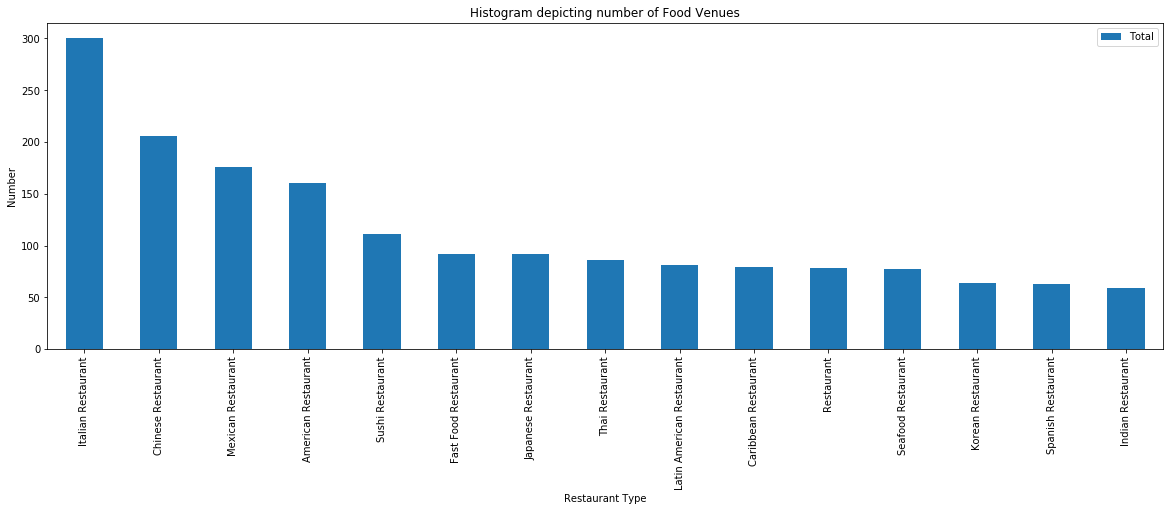

In [135]:
import matplotlib as mpl
import matplotlib.pyplot as plt
ny_sum.plot(kind='bar', figsize=(20,6))

plt.xlabel('Restaurant Type') # add to x-label to the plot
plt.ylabel('Number') # add y-label to the plot
plt.title('Histogram depicting number of Food Venues')

plt.show()

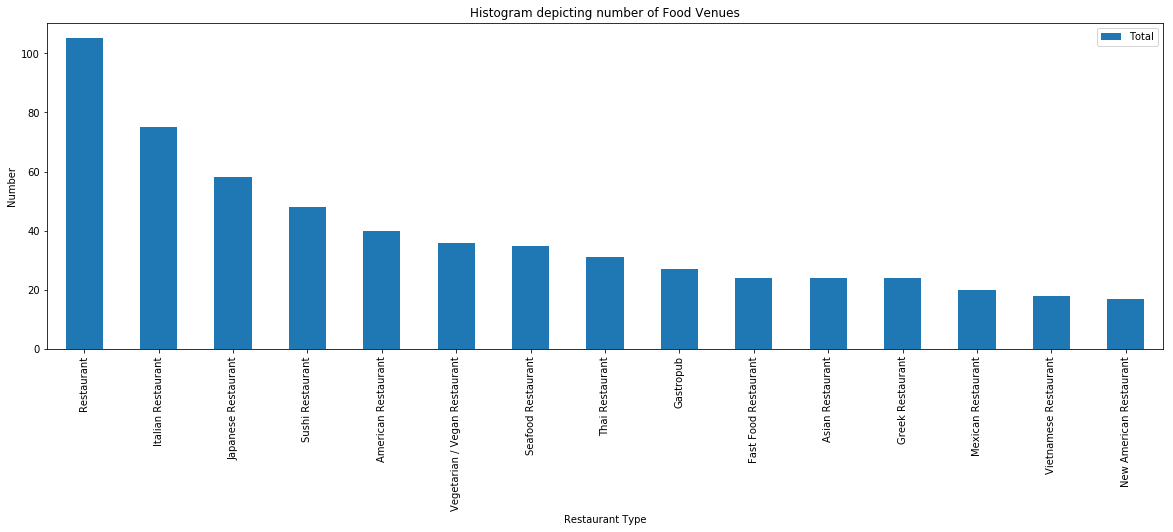

In [134]:
import matplotlib as mpl
import matplotlib.pyplot as plt
to_sum.plot(kind='bar', figsize=(20,6))

plt.xlabel('Restaurant Type') # add to x-label to the plot
plt.ylabel('Number') # add y-label to the plot
plt.title('Histogram depicting number of Food Venues')

plt.show()

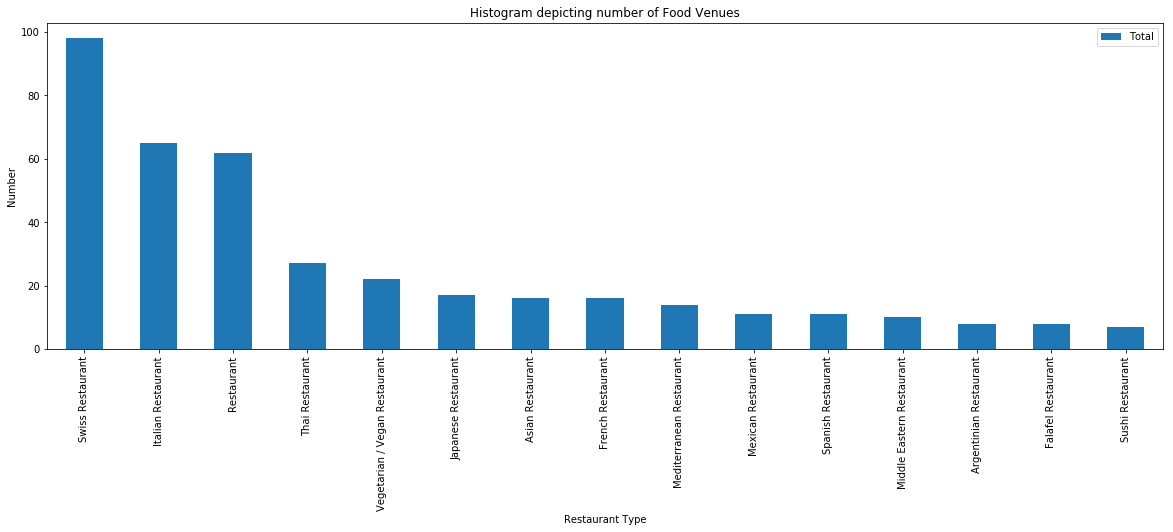

In [133]:
import matplotlib as mpl
import matplotlib.pyplot as plt
zh_sum.plot(kind='bar', figsize=(20,6))

plt.xlabel('Restaurant Type') # add to x-label to the plot
plt.ylabel('Number') # add y-label to the plot
plt.title('Histogram depicting number of Food Venues')

plt.show()

## Report on the analysis

#### 1. Introduction (discuss the business problem and who would be interested in this project)
NY, Toronto and Zurich share the common specificity of being the financial capitals of their country but not the administrative one. NY and Toronto are both North American cities with several millions of inhabitants and are therefore expected to share similar features regarding the number and types of venue. On the other hand, Zurich is a European city, significantly smaller and most likely much less cosmopolitan than NY or Toronto.

As imagined for our case study, an exploration analysis of the venues (for example in terms of types and density) can be very useful in order to get the big picture over the type economical terrain of cities. The advantage of this analysis is to rapidly obtain facts and figures that can support a business case, for instance for opening a restaurant. The advantage is that the data are available and can quickly be updated (you could even look at the evolution over time). Facts and figures are a pre requisite in order to convince banks and investors and are the start of every good business case.

__Business Problem:__ to gain a rapid basic market understanding of geographical areas (NY, Toronto, Zurich), based on an exploratory analysis of venues, in order to draw first conclusions based on facts and figures regarding the implementation of a new venue type in an area (indian restaurant).

__Stakeholders:__ futur owner of the new venue and investors in the new venue

#### 2. Data (describe the data that will be used to solve the problem and the source of the data)
Luckily, some data were already available from the previsous lab of this module:

- New York: Data are available as a json file dataset from Week 2
- Toronto: as seen during Week 3 of this module, the data can be downloaded out of a wikipedia page (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
- The Data for Zurich had to be search online and were found to be available on wikipedia too

The data had then to be pre-processed in order to obtain comparable dataset: the data were preprocessed into dataframes with 4 columns: Borough, Neighborhood, Latitude and Longitude.

#### 3. Methodology (discuss and describe the exploratory data analysis, inferential statistical testing, if any, and what machine learnings were used and why)
We followed standard method for Data Science analysis:

1. __Business understanding & analytical approach:__ we started by refining the problem to be solved and to think what could be the possible output of this analysis. One pre-requisite was to make sure that we had enough understanding of the business. This was ensured by the previsous labs on the module, that gave us sufficient insight to feel comfortable starting in that direction.
2. __Data requirement, collection, understanding and preparation:__ we had to obtain comparable datasets for each city, with the required quality and required informations. The first step was to determined if the dataset for each city was plausible and correct or not. Out of the previous labs, we knew that the dataset for NY and Toronto were correct and of good quality. Regarding the dataset for Zurich, we used our own knowledge of the city to assess the quality of the data. The format and size of the data was regularly checked by the use of the 'head' and 'shape' function in order to make sure that data were of good quality, size and format. Necessary adjustments were done when needed. The data had then to be pre-processed in order to obtain comparable dataset: the data were preprocessed into dataframes with 4 columns: Borough, Neighborhood, Latitude and Longitude. Once the data were prepared, the exploratory analysis could start: using Foursquare, results are easily accessible.
3. __Modelling and Evalutation:__ After data are prepared, one need to think of how can the data be used and visualised, and determine what additional visualisations could help us answer our business problem. First we explored the venues available within a defined radius around each neighborhoods. In order to compare the three cities, the radius was kept constant for each cities. Several radius were tried and it was decided that 500 was an appropriate radius, in order to be able to get all the venues within this radius without limitation of the Foursquare account. The previous step gave us the total number of venues available around all the neighborhoods and allowed for first comparison between the cities, data were displayed in tabular form (Dataframe). In a second phase, we called for the most common venues in each neighborhoods. Due to the important number of data, it was chosen to focus on the top 5 (frequency wise) and to display the data as histograms, in order to allow fast comparison. As As for any data analysis, the whole process of modeling and evaluation was highly iterative and the next step was always influenced by the results that we acquiring, sometimes confirming our hypothesis and sometimes denying it. Several lyouts were thought through before the final layout was decided.

#### 4. Results section where you discuss the results.
The results that we obtained from the analysis were, as very often, not always confirming our hypothesis. Our main results are the following:

1. Number of neighborhoods: we looked at the number of neighborhoods per city (siehe Dataframe xy). The city with the highest number of venue is NY, followed by Toronto and then by Zurich.
2. Density of venues: we calculated what is the density of venues per city and compared them between the three cities
3. Diversity: we look at the number of different type of venues per city, NY has the highest one.
4. Favorite Type: we looked at the favorite type of venue in each city. Difference can be seen.


####  5. Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
1. Number of neighborhoods:
    - we expected a correlation between the number of inhabitants and the number of neighborhoods.
    - This was confirmed by the results: the bigger the city, the higher the numbers of neighborhoods.
2. Density of venues:
    - we had expected a correlation between the size of a city and the density of venues per neighborhoods.
    - Surprisingly, the density and the number of inhabitants were not correlated. Zurich has a higher density of venues per neighborhood.
3. Diversity (number of different type of venues): we expected bigger city to have a higher diversity as expected bigger in bigger city (more cultural diversity?) fourth: top 5 venues type -> histogramm?

Critics:

- is the database for Zurich, NY and Toronto on Foursquare comparable? we know that some application are more popular in some places are other (for instance Whatsapp very popular in Europe but not in the US)
- is a neighborhood in Zurich equivalent to one in NY? number of inhabitants per neighborhood within a radius was here consired to be comparable, is it?
- a high number of indian restanrant is a sign that the population likes indian, but what is the tendency of time? going down or up? trends are more important than fix numbers / how can one asses the effect of concurrence?

Potential:
- Analyse the changes overtime
- get the premium version to make sure all the data where extracted and see more features (price, etc.)

#### 6. Conclusion section where you conclude the report.
Interesting example to see how data are readily available online. Number and types of analysis are endless Longest is the pre processing of the data and require knowledge of the business in order to provide relevant datas (and clean them)